# Zadanie nr 6 - Wzorce dwuwymiarowe

In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from time import time
import cv2

## 0. Funkcje pomocnicze

* funkcja wypisująca macierze 2D

In [3]:
def print2d(l): 
    print('\n'.join(map(''.join, list(map(lambda x: str(x).replace("'", ""), l)))), '\n')

* funkcja do wizualizacji grafu

Wykorzystuje bibliotekę networkx.

In [4]:
def show_graph(head):
    graph = nx.DiGraph()
    stack = [head]
    visited = set()

    while stack:
        node = stack.pop()
        for key, edge_node in node.edges.items():
            graph.add_edge(node, edge_node, label=key)

            if edge_node not in visited:
                stack.append(edge_node)

        if node.fail_link:
            graph.add_edge(node, node.fail_link)

        visited.add(node)
    
    plt.figure(figsize=(12, 7))
    pos = nx.spectral_layout(graph)
    nx.draw_networkx(
        graph, pos, connectionstyle='arc3, rad = 0.15', node_color='turquoise')
    labels = nx.get_edge_attributes(graph, 'label')
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels)
    plt.show()

* funkcja wyszukiwania wzorca w 1D z laboratorium nr 1

In [5]:
def kmp(text, pattern):
    result = []

    pi = prefix_function(pattern)
    q = 0

    for i in range(0, len(text)):
        while q > 0 and pattern[q] != text[i]:
            q = pi[q-1]

        if pattern[q] == text[i]:
            q = q + 1

        if q == len(pattern):
            result.append(i + 1 - q)
            q = pi[q-1]

    return result


def prefix_function(pattern):
    pi = [0]
    k = 0

    for q in range(1, len(pattern)):
        while(k > 0 and pattern[k] != pattern[q]):
            k = pi[k-1]

        if(pattern[k] == pattern[q]):
            k = k + 1

        pi.append(k)

    return pi

## 1. Algorytm

Elementarne testy kolejnych kroków algorytmu przeprowadzam dla następującego wzorca i tekstu:

In [6]:
pattern = ['abc', 'aab', 'cba']
text= ['bcdef', 'aabcg', 'aaabh', 'ccbai', 'aabbb', 'abccb']
print('--pattern--')
print2d(pattern)

print('--text--')
print2d(text)

--pattern--
abc
aab
cba 

--text--
bcdef
aabcg
aaabh
ccbai
aabbb
abccb 



<i>1. Zaimplementuj algorytm wyszukiwania wzorca 2-wymiarowego </i>

* struktura węzła

In [7]:
class Node:
    index = 0

    def __init__(self, parent=None, char=None):
        self.id = Node.index
        Node.index += 1
        
        self.edges = {}
        self.fail_link = None
        self.parent = parent
        self.char = char
        
        self.pattern_end = None

    def __str__(self):
        return str(self.id)

* budowa trie z podanych wzorców

In [213]:
def build_trie(patterns):
    Node.index = 0
    head = Node()

    for i, pattern in enumerate(patterns):
        current_node = head
        for char in pattern:
            if char in current_node.edges:
                current_node = current_node.edges[char]
            else:
                current_node.edges[char] = Node(char=char, parent=current_node)
                current_node = current_node.edges[char]

        if current_node.pattern_end is None:
            current_node.pattern_end = i+1

    return head

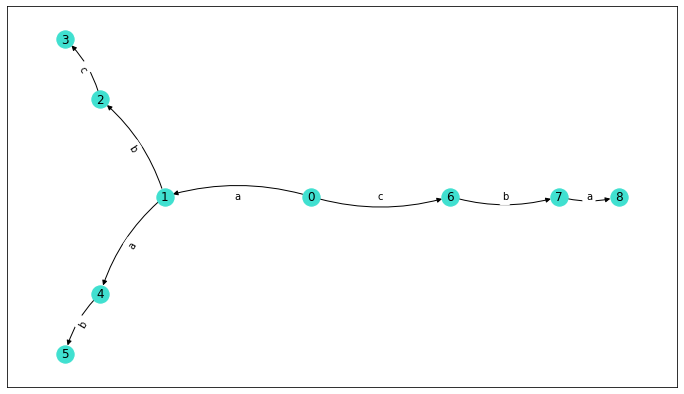

In [214]:
show_graph(build_trie(pattern))

* stworzenie podstawowej wersji automatu - dodanie faillinków do grafu

In [215]:
def build_automaton(patterns):
    head = build_trie(patterns)

    queue = [head]
    visited = []

    def assign_fail_links(node):
        if node is not head:
            current_node = node.parent.fail_link
            while current_node:
                if node.char in current_node.edges:
                    node.fail_link = current_node.edges[node.char]
                    break
                current_node = current_node.fail_link
            else:
                node.fail_link = head

        for edge in node.edges.values():
            if edge not in visited:
                queue.append(edge)

        visited.append(node)

    while queue:
        node = queue.pop(0)
        assign_fail_links(node)

    return head

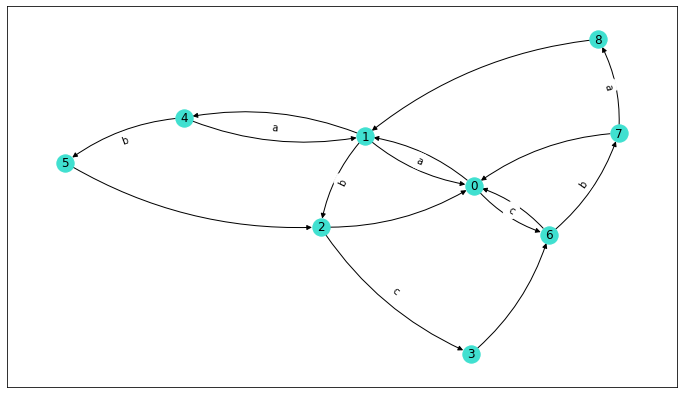

In [216]:
show_graph(build_automaton(pattern))

* modyfikacja automatu - usunięcie faillinków na rzecz zwiększenia liczby krawędzi

In [217]:
def modify_automaton(head):

    queue = [head]
    visited = []

    def copy_edges(node):
        if node is not head:
            for key, node_edge in node.fail_link.edges.items():
                if key not in node.edges:
                    node.edges[key] = node_edge

        for edge in node.edges.values():
            if edge not in visited and edge not in queue:
                queue.append(edge)
                visited.append(edge)

        visited.append(node)
        node.fail_link = None

    while queue:
        node = queue.pop(0)
        copy_edges(node)

    return head

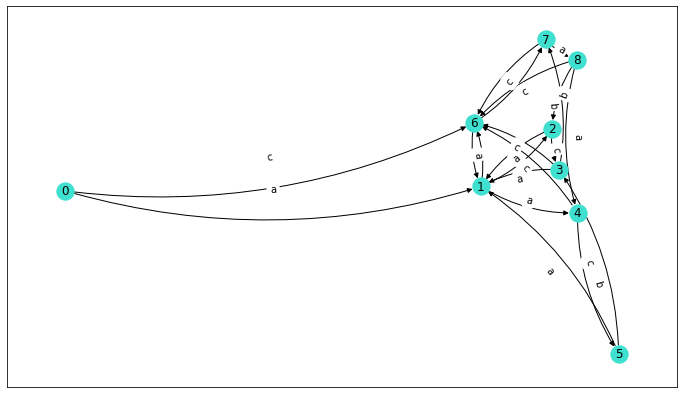

In [218]:
show_graph(modify_automaton(build_automaton(pattern)))

Oprócz tych krawędzi powinny być jeszcze od każdego do wierzchołka 0 powiązane z dowolnym symbolem. Zamiast tego w kodzie sprawdzam czy istnieje przejście po zadanym znaku, a jeśli go nie ma to wracam na start.

* funkcja znajdująca wszystkie wystąpienia wzorca dwuwymiarowego w strukturze 2d

In [396]:
def pattern_match_2d(text, pattern, printing=False, measure_times=False):
    
    if measure_times: start = time()
        
    col_pattern = [-1 for _ in range(len(pattern))]
    
    i = 1
    for j, line in enumerate(pattern):
        if col_pattern[j] != -1: continue
        for k in range(j, len(pattern)):
            if pattern[k] == line:
                col_pattern[k] = i
                
        i += 1
    
    reduced_pattern = []
    for i, line in enumerate(pattern):
        if line not in reduced_pattern:
            reduced_pattern.append(line)
    
    pattern = reduced_pattern

    head = build_automaton(pattern)
    head = modify_automaton(head)
    
    if measure_times: 
        build_time = time() - start
        start = time()
    
    height = len(text)
    width = len(max(text, key=len))
    

    patterns_matrix = [[0 for _ in range(width)]
                       for _ in range(height)]

    for i, line in enumerate(text):
        current_node = head
        for j, char in enumerate(line):
            if char in current_node.edges:
                current_node = current_node.edges[char]
            else:
                current_node = head

            if current_node.pattern_end:
                patterns_matrix[i][j] = current_node.pattern_end
    
    if printing:
        print2d(patterns_matrix)
    
    result = []

    for i in range(len(text[0])):
        line = [patterns_matrix[j][i] for j in range(height)]
#         print(line, col_pattern)
        for j in kmp(line, col_pattern):
            result.append((j, i-len(pattern[0])+1))
    
    if measure_times:
        end = time()
        search_time = end-start
        return result, build_time, search_time

#     print2d(result)
    return result

In [395]:
print('--pattern--')
print2d(pattern)

print('--text--')
print2d(text)

pattern_match_2d(text, pattern, printing=True)

--pattern--
abc
aab
cba 

--text--
bcdef
aabcg
aaabh
ccbai
aabbb
abccb 

[0, 0, 0, 0, 0]
[0, 0, 2, 1, 0]
[0, 0, 0, 2, 0]
[0, 0, 0, 3, 0]
[0, 0, 2, 0, 0]
[0, 0, 1, 0, 0] 



[(1, 1)]

Powyższa funkcja zwraca współrzędne lewego górnego rogu odnalezionych wzorców w strukturze text.

## 2. Testy

<i>2. Znajdź w załączonym pliku "haystack.txt" wszystkie sytuacje, gdy taka sama litera występuje na tej samej pozycji w dwóch kolejnych linijkach. Zwróć uwagę, na nierówną długość linii w pliku.</i>

* wczytanie teksytu z pliku i ustalenie alfabetu

In [248]:
with open('haystack.txt', 'r') as f:
    text_stack = [line.strip() for line in f]

# print2d(text_stack)
alphabet = set(char for line in text_stack for char in line if char.isalpha())
print(alphabet)

{'T', 'P', 'A', 'D', 'S', 'n', 'O', 'g', 'p', 'k', 'y', 'E', 'd', 'V', 'N', 'o', 'U', 'q', 'f', 'M', 'L', 'w', 'Q', 'i', 'm', 'C', 'e', 'r', 'h', 'u', 'v', 'l', 'c', 'F', 't', 'j', 'x', 'B', 'z', 's', 'G', 'b', 'W', 'X', 'a', 'R', 'I'}


In [249]:
sum_ = 0
for char in alphabet:
    count = len(pattern_match_2d(text_stack, [[char], [char]]))
    if count > 0:
        print(f'{char}: {count}')
        sum_ += count
    
print('any letter: ', sum_)

n: 15
p: 2
y: 1
d: 1
o: 21
f: 2
w: 2
i: 13
m: 5
e: 48
r: 21
h: 4
l: 5
c: 6
t: 41
x: 1
s: 19
a: 28
any letter:  235


<i>3. Znajdź wszystkie wystąpienia "th" oraz "t h" w dwóch kolejnych liniach na tej samej pozycji.</i>

In [250]:
print('th:')
print(pattern_match_2d(text_stack, ["th", "th"]))

th:
[]


In [251]:
print('th:')
print(pattern_match_2d(text_stack, ["t h", "t h"]))

th:
[(37, 0)]


In [252]:
print2d(text_stack[37:39])

t h a t if inflected forms are considered. In French, inflected forms produce more
t h a n 700,000 words. T h e representation of lexicons of this size makes the 



<i>4. Wybierz przynajmniej 3 litery (małe). Znajdź wszystkie wystąpienia tej litery w załączonym pliku "haystack.png"</i>

In [291]:
def count_letters(text, letter):
    return sum(1 for line in text_stack for char in line if char == letter)

In [292]:
def to_list(array):
    n, m, p = array.shape
    array = array.tolist()
    for i in range(n):
        for j in range(m):
            array[i][j] = tuple(array[i][j][k] for k in range(p))
    return array

In [293]:
image = cv2.imread('haystack.png')

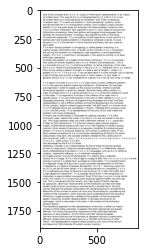

In [294]:
plt.imshow(image)

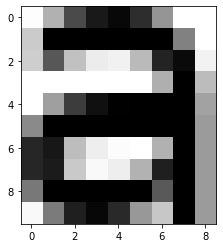

In [295]:
a_image = image[125:135, 274:283]
plt.imshow(a_image)

In [311]:
print('found on image: ', len(found := pattern_match_2d(to_list(image), to_list(a_image))))
print('actual letter count: ', count_letters(text_stack, 'a'))
print('cut letter in list of found letters? ', (125, 274) in found)

found on image:  397
actual letter count:  397
cut letter in list of found letters?  True


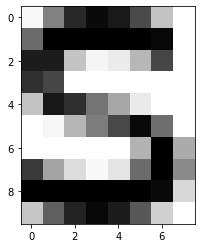

In [312]:
s_image = image[103:113, 31:39]
plt.imshow(s_image)

In [313]:
print('found on image: ', len(found := pattern_match_2d(to_list(image), to_list(s_image))))
print('actual letter count: ', count_letters(text_stack, 's'))
print('cut letter in list of found letters? ', (103, 31) in found)

found on image:  334
actual letter count:  334
cut letter in list of found letters?  True


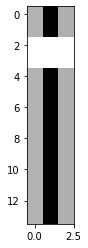

In [314]:
i_image = image[825:839, 724:727]
plt.imshow(i_image)

In [315]:
print('found on image: ', len(found := pattern_match_2d(to_list(image), to_list(i_image))))
print('actual letter count: ', count_letters(text_stack, 'i'))
print('cut letter in list of found letters? ', (825, 724) in found)

found on image:  343
actual letter count:  352
cut letter in list of found letters?  True


<i>5. Znajdź wszystkie wystąpienia słowa "p a t t e r n" w haystack.png.</i>

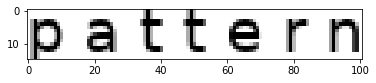

In [357]:
pattern_image = image[540:555, 241:342]
plt.imshow(pattern_image)

In [363]:
print('found on image: ', len(found := pattern_match_2d(to_list(image), to_list(pattern_image))))
print('found in text: ', len(pattern_match_2d(text_stack, ['p a t t e r n'])))
print('cut letter in list of found letters? ', (540, 241) in found)

found on image:  5
found in text:  5
cut letter in list of found letters?  True


## 3. Porównanie czasów

<i>6. Porównaj czas budowania automatu i czas wyszukiwania dla różnych rozmiarów wzorca</i>

In [502]:
def compare_times():
    build_times = []
    search_times = []
    ns = list(range(10, 80, 6))
    
    for n in ns:
        pattern = to_list(image[:n, :n, :])
        _, build_time, search_time = pattern_match_2d(to_list(image), pattern, measure_times=True)
        build_times.append(build_time)
        search_times.append(search_time)
        
    fig, ax = plt.subplots(1, 3, figsize=(15, 6))
    ax[0].plot(ns, build_times, label='building', color='cyan')
    ax[0].plot(ns, search_times, label='searching', color='darkgreen')
    ax[0].legend()
    
    ax[1].plot(ns, build_times, label='building', color='cyan')
    ax[2].plot(ns, search_times, label='searching', color='darkgreen')
#     print(build_times, search_times)
    


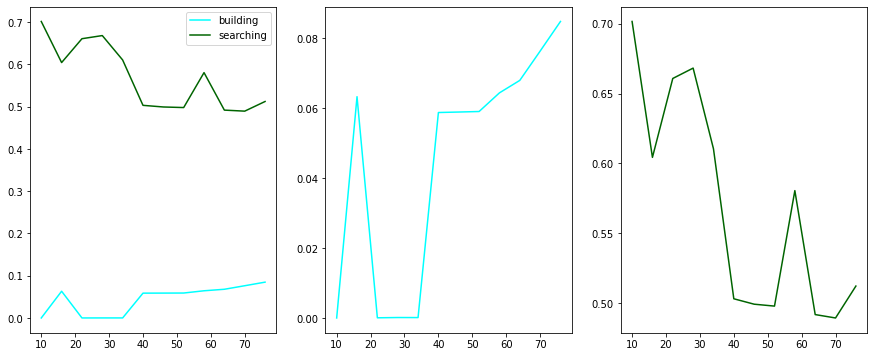

In [503]:
compare_times()

<i>7. Podziel plik na 2, 4 i 8 fragmentów (w poziomie) i porównaj czas przeszukiwania</i>

In [509]:
def divide_and_match(text, pattern):
    build_times = []
    search_times = []
    ns = [1, 2, 4, 8]
    
    for n in ns:
        build_time = 0
        search_time = 0
        for i in range(n):
            to = (i+1)*n if i != n-1 else -1
            text_part = text[i*n:to, :, :]
            _, b_t, s_t = pattern_match_2d(to_list(text_part), to_list(pattern), measure_times=True)
            build_time += b_t
            search_time += s_t
        
        print(f'n: {n}, build time: {build_time}, search time: {search_time}')
        build_times.append(build_time)
        search_times.append(search_time)
        
    fig, ax = plt.subplots(figsize=(15, 6))
    ax.plot(ns, build_times, label='building', color='cyan')
    ax.plot(ns, search_times, label='searching', color='darkgreen')
    ax.legend()

n: 1, build time: 0.05762672424316406, search time: 0.4084184169769287
n: 2, build time: 0.0009021759033203125, search time: 0.459000825881958
n: 4, build time: 0.05870938301086426, search time: 0.4080491065979004
n: 8, build time: 0.06010270118713379, search time: 0.4091026782989502


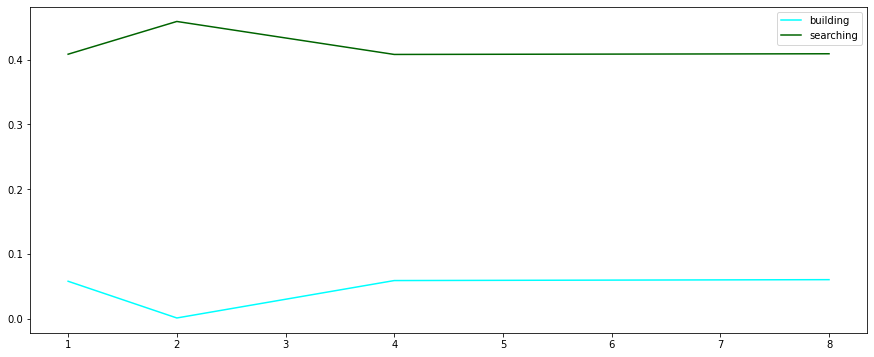

In [510]:
divide_and_match(image, a_image)

## Wnioski

- Algorytm Aho-Corasick pozwala na równoczesne odnalezienie kilku wzorców w tekście.
- Jesteśmy w stanie dopasować dwywymiarowy wzorzec w czasie kwadratowym.

M. Hawryluk 03.06.2021